<a href="https://colab.research.google.com/github/Newborn1937/zdetect/blob/main/z_avatar_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import datetime
import os
from pathlib import Path
import pickle

import gdown
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# Load utilities
urls = ['https://raw.githubusercontent.com/Newborn1937/zdetect/main/vk_utils.py',
        'https://raw.githubusercontent.com/Newborn1937/zdetect/main/reg_dates.py']
for url in urls:
  gdown.download(url, quiet=True)

from reg_dates import get_user_reg_date

#### Settings

In [17]:
DIRPATH_ROOT = Path('content/zresult')

time_interval = '2021_22'
#time_interval = 'all'

if time_interval == '2021_22':
    GROUP_NAMES = ['putin_z', 'random_around_24Feb']
else:
    GROUP_NAMES = ['putin_z', 'random_1e6']

# User idx for '2021_22' interval
USER_ID_RANGE_2021_22 = (6.82e8, 7.33e8)

need_get_z_idx_from_fnames = False

group_data = {}
for group_name in GROUP_NAMES:
    group_data[group_name] = {
        'name': group_name,
        'fpath_users_info': DIRPATH_ROOT / group_name / 'users.pkl',
        'dirpath_work': DIRPATH_ROOT / group_name,
        'fpaths_z': [DIRPATH_ROOT.parent / group_name / 'avatars' / f'{group_name}_z']
    }

In [18]:
SRC_DATA_URL = 'https://drive.google.com/drive/folders/1ukcET8oEqUXF3ZhCVz4GcWh_2BXFWxlB?usp=drive_link'

!gdown -q --fuzzy --folder "$SRC_DATA_URL" -O "$DIRPATH_ROOT"

#### Analyze users' info: active, last seen, has an avatar

In [19]:
#### Load users' info from disk
for group in group_data.values():
    with open(group['fpath_users_info'], 'rb') as fid:
        users = pickle.load(fid)
    if isinstance(users, list):
        users = {user['id']: user for user in users}
    group['users'] = users

In [20]:
def categorize_users(group):

    # All sampled users
    users = group['users']
    user_idx = list(users.keys())
    user_idx = np.array(user_idx)

    # Take subset of users
    mask = ((user_idx > USER_ID_RANGE_2021_22[0]) &
            (user_idx < USER_ID_RANGE_2021_22[1]))
    if time_interval == '2021_22':
        user_idx = user_idx[mask]

    # Active / inactive users
    user_idx_active = [user_id for user_id in user_idx
                       if 'deactivated' not in users[user_id]]
    user_idx_active = np.array(user_idx_active)

    # Users who have avatars
    user_idx_photo = [user_id for user_id in user_idx_active
                      if users[user_id]['has_photo'] == True]
    user_idx_photo = np.array(user_idx_photo)

    # Users with information about 'last seen' date
    user_idx_last_seen = [user_id for user_id in user_idx_active
                          if 'last_seen' in users[user_id].keys()]
    user_idx_last_seen = np.array(user_idx_last_seen)

    # Dates at which users were last seen
    last_seen_vec = {
        user_id: datetime.datetime.fromtimestamp(users[user_id]['last_seen']['time'])
        for user_id in user_idx_last_seen
    }

    # Users who were last seen after the beginning of the war
    war_start_date = datetime.datetime.strptime('24-02-2022', '%d-%m-%Y').date()
    user_idx_seen_during_war = [user_id for user_id in user_idx_last_seen
                                if last_seen_vec[user_id].date() >= war_start_date]
    user_idx_seen_during_war = np.array(user_idx_seen_during_war)

    # Users with avatars, who were last seen after the beginning of the war
    user_idx_photo_seen_during_war = [
            user_id for user_id in user_idx_last_seen
            if users[user_id]['has_photo'] == True
            and last_seen_vec[user_id].date() >= war_start_date]
    user_idx_photo_seen_during_war = np.array(user_idx_photo_seen_during_war)

    group |= {
        'user_idx': user_idx,
        'user_idx_active': user_idx_active,
        'user_idx_photo': user_idx_photo,
        'user_idx_last_seen': user_idx_last_seen,
        'last_seen_vec': last_seen_vec,
        'user_idx_seen_during_war': user_idx_seen_during_war,
        'user_idx_photo_seen_during_war': user_idx_photo_seen_during_war
    }

    # Print summary
    Nsampled = len(user_idx)
    Nactive = len(user_idx_active)
    Nphoto = len(user_idx_photo)
    Nseen = len(user_idx_seen_during_war)
    print(f'==== GROUP: {group["name"]} ====')
    print(f'Total: {Nsampled}')
    print(f'Active: {Nactive}  (active / total: {Nactive / Nsampled :.02f})')
    print(f'With_photo: {Nphoto}  (with_photo / active: {Nphoto / Nactive :.02f})')
    print(f'Seen_during_war: {Nseen}  (seen_during_war / active: {Nseen / Nactive :.02f})')
    print()


#### Categorize the users
for group in group_data.values():
    categorize_users(group)

==== GROUP: putin_z ====
Total: 18114
Active: 18114  (active / total: 1.00)
With_photo: 13983  (with_photo / active: 0.77)
Seen_during_war: 18007  (seen_during_war / active: 0.99)

==== GROUP: random_around_24Feb ====
Total: 317776
Active: 194901  (active / total: 0.61)
With_photo: 58278  (with_photo / active: 0.30)
Seen_during_war: 126705  (seen_during_war / active: 0.65)



#### Find users with Z-avatars

In [21]:
def find_z_users(group):

    fpath_z_idx = group['dirpath_work'] / f'z_user_idx_{time_interval}.npy'
    if not fpath_z_idx.exists() or need_get_z_idx_from_fnames:
        # Get indices of z-users from filenames
        files = []
        for fpath in group['fpaths_z']:
            files += os.listdir(fpath)
        user_idx_z = np.array([int(fname[:-4]) for fname in files])
        # Save the indices
        np.save(fpath_z_idx, user_idx_z)
    else:
        # Load the indices
        user_idx_z = np.load(fpath_z_idx)

    # Select users from the given time interval
    user_idx_z = np.asarray([i for i in user_idx_z if i in group['user_idx']])

    # Z-users who was seen during the war
    user_idx_z_seen_during_war = [user_id for user_id in user_idx_z
                                  if user_id in group['user_idx_photo_seen_during_war']]
    user_idx_z_seen_during_war = np.array(user_idx_z_seen_during_war)

    # Check that all z-users were active during the war
    for user_id in user_idx_z:
        if ((user_id in group['user_idx_last_seen']) and
            (user_id not in group['user_idx_seen_during_war'])):
            last_seen = group['ast_seen_vec'][user_id]
            print(f'Z-user {user_id} was last seen {last_seen}')

    group |= {
        'user_idx_z': user_idx_z,
        'user_idx_z_seen_during_war': user_idx_z_seen_during_war
    }

    # Print summary
    Nz = len(user_idx_z)
    Nz_seen = len(user_idx_z_seen_during_war)
    print(f'==== GROUP: {group["name"]} ====')
    print(f'Z_users: {Nz}  (Z_users / with_photo: {Nz / len(group["user_idx_photo"]) :.04f})')
    print(f'Z_users seen during war: {Nz_seen}  (Z_users_seen / Z_users: {Nz_seen / Nz :.04f})')
    print()


#### Find z-users
for group in group_data.values():
    find_z_users(group)

==== GROUP: putin_z ====
Z_users: 47  (Z_users / with_photo: 0.0034)
Z_users seen during war: 47  (Z_users_seen / Z_users: 1.0000)

==== GROUP: random_around_24Feb ====
Z_users: 77  (Z_users / with_photo: 0.0013)
Z_users seen during war: 75  (Z_users_seen / Z_users: 0.9740)



#### Calculate user disributions by their registration dates

In [22]:
#### Calculate histograms
def calc_user_histograms(group):
    # Histograms: all, active
    nbins = 50
    h_active, hbins = np.histogram(group['user_idx_active'], nbins)
    h_all, _ = np.histogram(group['user_idx'], hbins)
    h_all_norm = h_all / np.sum(h_all)
    h_active_norm = h_active / np.sum(h_active)

    # Histogram and percentage of users having avatars
    h_photo, _ = np.histogram(group['user_idx_photo'], hbins)
    perc_photo_act = h_photo / h_active

    # Histogram and percentage of users seen during the war
    h_last_seen, _ = np.histogram(group['user_idx_last_seen'], hbins)
    h_war, _ = np.histogram(group['user_idx_seen_during_war'], hbins)
    h_war_photo, _ = np.histogram(group['user_idx_photo_seen_during_war'], hbins)
    perc_lastseen_act = h_last_seen / h_active
    perc_warphoto_photo = h_war_photo / h_photo

    # Histogram of z-users
    h_z, _ = np.histogram(group['user_idx_z'], hbins)
    h_war_z, _ = np.histogram(group['user_idx_z_seen_during_war'], hbins)
    perc_z_photo = h_z / h_photo
    perc_warz_warphoto = h_war_z / h_war_photo

    group |= {'hbins': hbins, 'h_all': h_all, 'h_active': h_active,
              'h_all_norm': h_all_norm, 'h_active_norm': h_active_norm,
              'h_photo': h_photo, 'perc_photo_act': perc_photo_act,
              'h_last_seen': h_last_seen, 'perc_lastseen_act': perc_lastseen_act,
              'h_war': h_war, 'h_war_photo': h_war_photo,
              'perc_warphoto_photo': perc_warphoto_photo,
              'h_z': h_z, 'h_war_z': h_war_z, 'perc_z_photo': perc_z_photo,
              'perc_warz_warphoto': perc_warz_warphoto
             }

In [23]:
#### Convert histogram bins from user idx to dates
def hist_bins_to_reg_dates(group, need_get_reg_dates=False):

    fpath_reg_dates = Path(group['dirpath_work']) / f'reg_dates_{time_interval}.csv'
    hbins = group['hbins']

    if not fpath_reg_dates.exists() or need_get_reg_dates:
        # User ID -> Rregistration date
        hbins_t = []
        for hbin in tqdm(hbins):
            hbins_t.append(get_user_reg_date(int(hbin)))
        hbins_t = np.asarray(hbins_t)

        # Save ID-date mapping
        df = pd.DataFrame({'ID': hbins.astype(int), 'reg_date': hbins_t})
        df.to_csv(fpath_reg_dates, index=False)

    else:
        # Load the existing ID-date mapping
        df = pd.read_csv(fpath_reg_dates, parse_dates=['reg_date'])
        hbins_t = df['reg_date'].to_numpy()
        #hbins_t = np.array([datetime.date.fromisoformat(d) for d in hbins_t])

        # Check user ID consistency
        hbins_loaded = df['ID'].to_numpy()
        if not np.all(hbins_loaded == hbins.astype(int)):
            #raise ValueError('Loaded user IDs are inconsistent with histogram bins')
            print('Loaded user IDs are inconsistent with histogram bins')
            hist_bins_to_reg_dates(group, need_get_reg_dates=True)

    group['hbins_t'] = hbins_t

In [24]:
#### Calculate user idx histograms and convert itx to reg dates
for group_name, group in group_data.items():
    print(group_name)
    calc_user_histograms(group)
    hist_bins_to_reg_dates(group, need_get_reg_dates=False)

putin_z
random_around_24Feb


#### Visualize the results

In [25]:
def smooth(y, kernel_sz):
    #K = np.ones(kernel_sz)
    K = np.hanning(kernel_sz + 2)[1 : -1]
    K = K / np.sum(K)
    y_smooth = np.convolve(y, K, mode='same')
    return y_smooth

def plot_with_dates(tvec, xvec, title_str, label,
                    style='-', linewidth=1, ax=None):
    ax = ax or plt.gca()
    for tick in ax.get_xticklabels():
        tick.set_rotation(70)
    #ax.plot([], [])
    ax.plot(tvec, xvec, style, linewidth=linewidth, label=label)
    #plt.xlabel('Days')
    #ax.legend()
    ax.tick_params(axis="y", colors=style[0])
    plt.title(title_str)
    if time_interval == '2021_22':
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%y'))
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m.%y'))

def combined_legend(loc=None):
    handles, labels = [], []
    fig = plt.gcf()
    for ax_ in fig.axes:
        h, l = ax_.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    loc = loc or 'best'
    plt.gca().legend(handles, labels, loc=loc)

cols = ['r', 'b']

def plot_group_data(group_data, var, title, legend_loc=None):
    ax = [plt.gca(), plt.gca().twinx()]
    for n, (group_name, group) in enumerate(group_data.items()):
        plot_with_dates(group['hbins_t'][1:], group[var], style=f'{cols[n]}',
                        title_str=title, label=group_name, ax=ax[n])
    combined_legend(legend_loc)

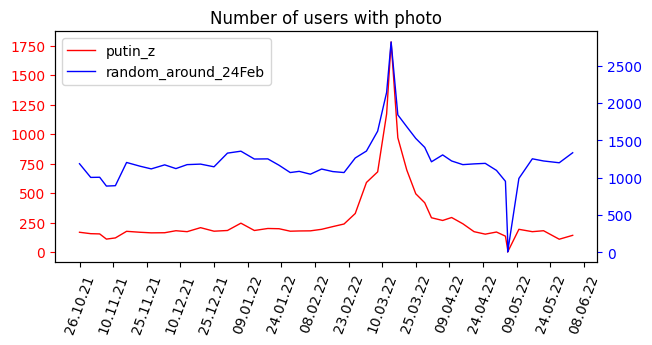

In [26]:
# Plot number of users with photo
plt.figure(figsize=(7, 3))
plot_group_data(group_data, 'h_photo', 'Number of users with photo')

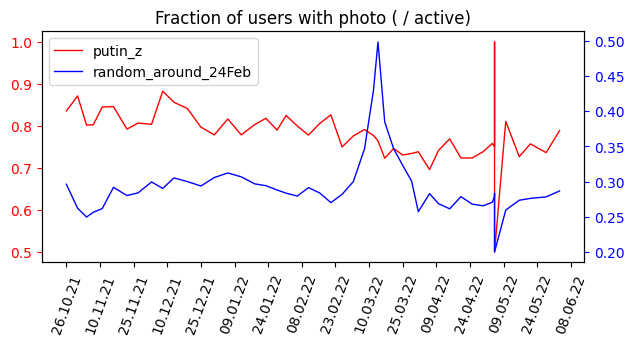

In [27]:
# Plot percentage of users with photo (# photo / # active)
plt.figure(figsize=(7, 3))
plot_group_data(group_data, 'perc_photo_act', 'Fraction of users with photo ( / active)')

In [28]:
# Smooth z-avatar hitograms
for group in group_data.values():
    group['h_z_sm'] = smooth(group['h_z'], 7)
    group['perc_z_photo_sm'] = smooth(group['perc_z_photo'], 7)

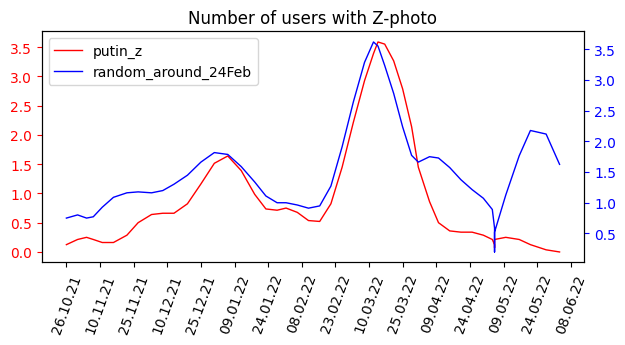

In [29]:
# Plot number of z-users
plt.figure(figsize=(7, 3))
plot_group_data(group_data, 'h_z_sm', 'Number of users with Z-photo')

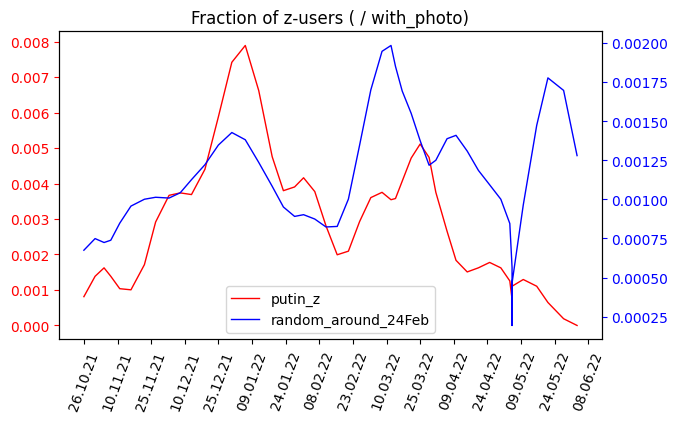

In [30]:
# Plot percentage of z-users among the users with photo
plt.figure(figsize=(7, 4))
plot_group_data(group_data, 'perc_z_photo_sm',
                'Fraction of z-users ( / with_photo)',
                legend_loc='lower center')